# 目的
tickerレベルでのOHLCを分析する。

In [1]:
from datetime import datetime
import glob
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import numpy as np
import os
import pandas as pd

%matplotlib inline

In [2]:
from datetime import datetime
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

def make_ohlc_by_step(y, step=60):
    """make_ohlc_by_step(y, step) -> numpy.2darray
    calculate OHLC from a given array-like object
    
    Parameters
    ----------
    y : list or numpy.1darray
        target data series
    step : int (default : 60)
        step for OHLC
    
    Returns
    -------
    ohlc_ : numpy.2darray
        OHLC data
    """
    if isinstance(y, list):
        y = np.array(y)
    if step <= 0:
        raise ValueError("'step' must be larger than 0.")
    if not isinstance(step, int):
        raise TypeError("'step' must be integer.")
    nbr_of_candles = len(y) // step
    if len(y) % step != 0:
        nbr_of_candles += 1
    
    def f(x):
        if len(x) > 1:
            return np.array([x[0], x.max(), x.min(), x[-1]])
        else:
            return np.array([x[0], x[0], x[0], x[0]])
    
    ohlc_ = np.zeros((nbr_of_candles, 4), dtype=int)
    for ii in range(nbr_of_candles - 1):
        y_ = y[ii*step:(ii+1)*step]
        ohlc_[ii] = f(y_)
    ii += 1
    y_ = y[ii*step:]
    if len(y) >= 1:
        ohlc_[ii] = f(y_)

    return ohlc_

def pickup_by_step(y, step=60):
    """pickup_by_step(y, step) -> numpy.1darray
    pick up values from a given data series every 'step'
    
    Parameters
    ----------
    y : list or numpy.1darray
        target data series
    step : int (default : 60)
        step
    
    Returns
    -------
    picked-up values : numpy.1darray
    """
    if isinstance(y, list):
        y = np.array(y)
    if step <= 0:
        raise ValueError("'step' must be larger than 0.")
    if not isinstance(step, int):
        raise TypeError("'step' must be integer.")
    nbr_of_candles = len(y) // step
    if len(y) % step != 0:
        nbr_of_candles += 1
    y_ = []
    for ii in range(nbr_of_candles - 1):
        y_.append(y[(ii+1)*step-1])
    y_.append(y[-1])

    return np.array(y_)

def make_ohlc_dataframe_by_step(data, step=60):
    """make_ohlc_dataframe_by_step(data, step) -> pandas.DataFrame
    make a DataFrame object including the following columns from a given DataFrame object 'data':
    'Date', 'Open', 'High',
    
    Parameters
    ----------
    data : pandas.DataFrame
        'data' must have at least the two field: 'ltp' and 'timestamp'.
        Every element in 'timestamp' column must have "%Y-%m-%dT%H:%M:%S" format.
    step : int (default : 60)
        step for OHLC
    
    Returns
    -------
    df : pandas.DataFrame
    """
    ohlc_ = make_ohlc_by_step(data["ltp"].values, step)
    timestamp = pickup_by_step(data["timestamp"].values, step)
    timestamp_mdates = [mdates.date2num(datetime.strptime(ts.split(".")[0], "%Y-%m-%dT%H:%M:%S")) for ts in timestamp]
    columns = ["Open", "High", "Low", "Close"]
    df = pd.DataFrame(ohlc_, columns=columns)
    df["Date"] = np.array(timestamp_mdates)
    return df

class dataAdapter(object):
    """dataAdapter(object)
    base class for adapter of dataset obtained from bitFlyer by the ticker API
    """
    def __init__(self, data, step=60):
        """__init__(self, filepath, step=60) -> None
        initialize this class
        
        Parameters
        ----------
        data : str or pandas.DataFrame
            if str then it is treated as path of file
        step : int
            step for making OHLC dataset
        """
        self.step = step
        self.loadData(data)
    
    @property
    def original_data(self):
        """original_data(self) -> pandas.DataFrame
        return the original data
        """
        return self._data
    
    def loadData(self, *args):
        """loadData(self, *args) -> None
        load data
        
        Parameters
        ----------
        args[0] : str or pandas.DataFrame
            if str then it is treated as path of file
        """
        if len(args) == 0:
            return
        if isinstance(args[0], str):
            self._data = pd.read_csv(filepath, index_col=0)
        elif isinstance(args[0], pd.DataFrame):
            self._data = args[0]
        self.__makeOhlcDataFrameByStep()
    
    def __makeOhlcDataFrameByStep(self):
        """__makeOhlcDataFrameByStep(self) -> None
        internal wrapper function of make_ohlc_dataframe_by_step(data, step)
        """
        self._df_OHLC = make_ohlc_dataframe_by_step(self._data, self.step)
    
    @property
    def df_OHLC(self):
        """df_OHLC(self) -> pd.DataFrame
        return the OHLC dataset as pandas.DataFrame
        """
        return self._df_OHLC

In [3]:
from scipy.signal import lfilter

def calc_EMA(x, N=5):
    """calc_EMA(x, N) -> array-like
    calculate exponential moving average (EMA)
    
    Parameters
    ----------
    x : array-like
        target data series
    N : int (default : 5)
        step for EMA
    
    Returns
    -------
    EMA : array-like
    """
    return _calc_EMA(x, 2./(N + 1.))

def _calc_EMA(x, alpha):
    """ _calc_EMA(x, alpha) -> array-like
    calculate exponential moving average (EMA)
    Adopted from https://qiita.com/toyolab/items/6872b32d9fa1763345d8
    
    Parameters
    ----------
    x : array-like
        target data series
    alpha : float
        characteristic parameter
    
    Returns
    -------
    EMA : array-like
    """
    y,_ = lfilter([alpha], [1,alpha-1], x, zi=[x[0]*(1-alpha)])
    return y

def calc_SMA(df, key="Close", N=5):
    """calc_SMA(df, key="Close", N=5) -> numpy.1darray
    calculate simple moving average (SMA)
    
    Parameters
    ----------
    df : pandas.DataFrame
        dataframe including target data
    key : str (default : 'Close')
        key to the target data
    N : int (default : 5)
        step for SMA
    
    Returns
    -------
    SMA : numpy.1darray
    """
    return df[key].rolling(5).mean().values

def find_cross_points(y1, y2):
    """find_cross_points(y1, y2) -> numpy.1darray
    find cross points between two data sequences
    
    Parameters
    ----------
    y1 : list or numpy.1darray
    y2 : list or numpy.1darray
    
    Returns
    -------
    cross_points : numpy.1darray
    """
    if isinstance(y1, list):
        y1 = np.array(y1)
    if isinstance(y2, list):
        y2 = np.array(y2)
    cross_points = np.zeros(len(y1))
    for ii in range(1, len(y1)):
        if y1[ii - 1] >= y2[ii - 1] and y1[ii] < y2[ii]:
            cross_points[ii] = -1
        elif y1[ii - 1] < y2[ii - 1] and y1[ii] >= y2[ii]:
            cross_points[ii] = 1
    return cross_points

## データの読み込み

In [4]:
fldrpath = r"C:\Users\take9\Desktop\data_"
filelist = glob.glob(os.path.join(fldrpath, "*.csv"))
print(len(filelist))

2646


In [5]:
index_data = 300
data = pd.read_csv(filelist[index_data], index_col=0)
data.head()

,timestamp,ltp,best_bid,volume,tick_id,best_ask_size,total_bid_depth,product_code,total_ask_depth,best_bid_size,volume_by_product,best_ask
0,2018-07-29T22:01:34.833,951501.0,951501.0,124615.644821,11299146,48.272,8112.182730,FX_BTC_JPY,10754.334086,31.570000,120149.028964,951502.0
1,2018-07-29T22:01:36.05,951502.0,951501.0,124619.280824,11299272,51.002,8093.189766,FX_BTC_JPY,10755.684086,32.930997,120152.664967,951502.0
2,2018-07-29T22:01:37.13,951501.0,951501.0,124627.022824,11299388,13.944,8079.334346,FX_BTC_JPY,10727.690086,6.063997,120160.584967,951502.0
3,2018-07-29T22:01:37.927,951504.0,951504.0,124653.485824,11299522,13.390,8073.918730,FX_BTC_JPY,10716.846086,0.830000,120187.045967,951505.0
4,2018-07-29T22:01:38.99,951504.0,951504.0,124653.645824,11299676,42.828,8084.624831,FX_BTC_JPY,10742.964086,22.416000,120187.205967,951505.0


## OHLC + Timestampの用意

In [6]:
df = make_ohlc_dataframe_by_step(data)
df.head()

,Open,High,Low,Close,Date
0,951501,951598,950832,951598,736904.918438
1,951599,951695,951165,951692,736904.919144
2,951692,951692,950854,950856,736904.919838
3,950856,951955,950856,951955,736904.920532
4,951955,952004,951955,952003,736904.921227


## ローソク足のプロット

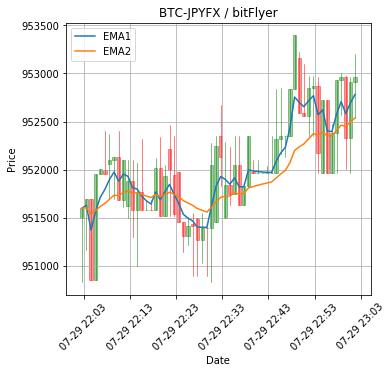

In [7]:
def plot(df):
    columns = ["Date", "Open", "High", "Low", "Close"]
    tuples = [tuple(x) for x in df[columns].values]
    
    fig = plt.figure(figsize=(12, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.xaxis_date()
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
    ax1.grid(True)
    plt.xticks(rotation=45)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("BTC-JPYFX / bitFlyer")
    candlestick_ohlc(ax1, tuples, width=0.0005,colorup='g', alpha =.4)
    
    x = df["Date"].values
    ema1 = calc_EMA(df["Close"].values, 5)
    ema2 = calc_EMA(df["Close"].values, 20)
    ax1.plot(x, ema1, label="EMA1")
    ax1.plot(x, ema2, label="EMA2")
    
    plt.legend()
    return fig, ax1

plot(df);

## 複数データの読み込み

In [106]:
data = None
start_file = 2000
nbr_of_files = 500
for ii in range(start_file, start_file + nbr_of_files):
    data_ = pd.read_csv(filelist[ii], index_col=0)
    if data is None:
        data = data_
    else:
        data = pd.concat([data, data_], ignore_index=True, sort=True)

In [107]:
data["ltp"].shape, data["timestamp"].shape

((1800000,), (1800000,))

In [108]:
df = make_ohlc_dataframe_by_step(data)
df.head(), len(df)

(     Open    High     Low   Close           Date
 0  711700  712100  711700  711976  736981.193600
 1  711950  712476  711950  712207  736981.194294
 2  712221  712238  711701  711736  736981.194988
 3  711711  711821  711538  711650  736981.195683
 4  711629  711634  711411  711620  736981.196377, 30000)

In [109]:
N1 = 5; N2 = 20;
ema1 = calc_EMA(df["Close"].values, N1)
ema2 = calc_EMA(df["Close"].values, N2)

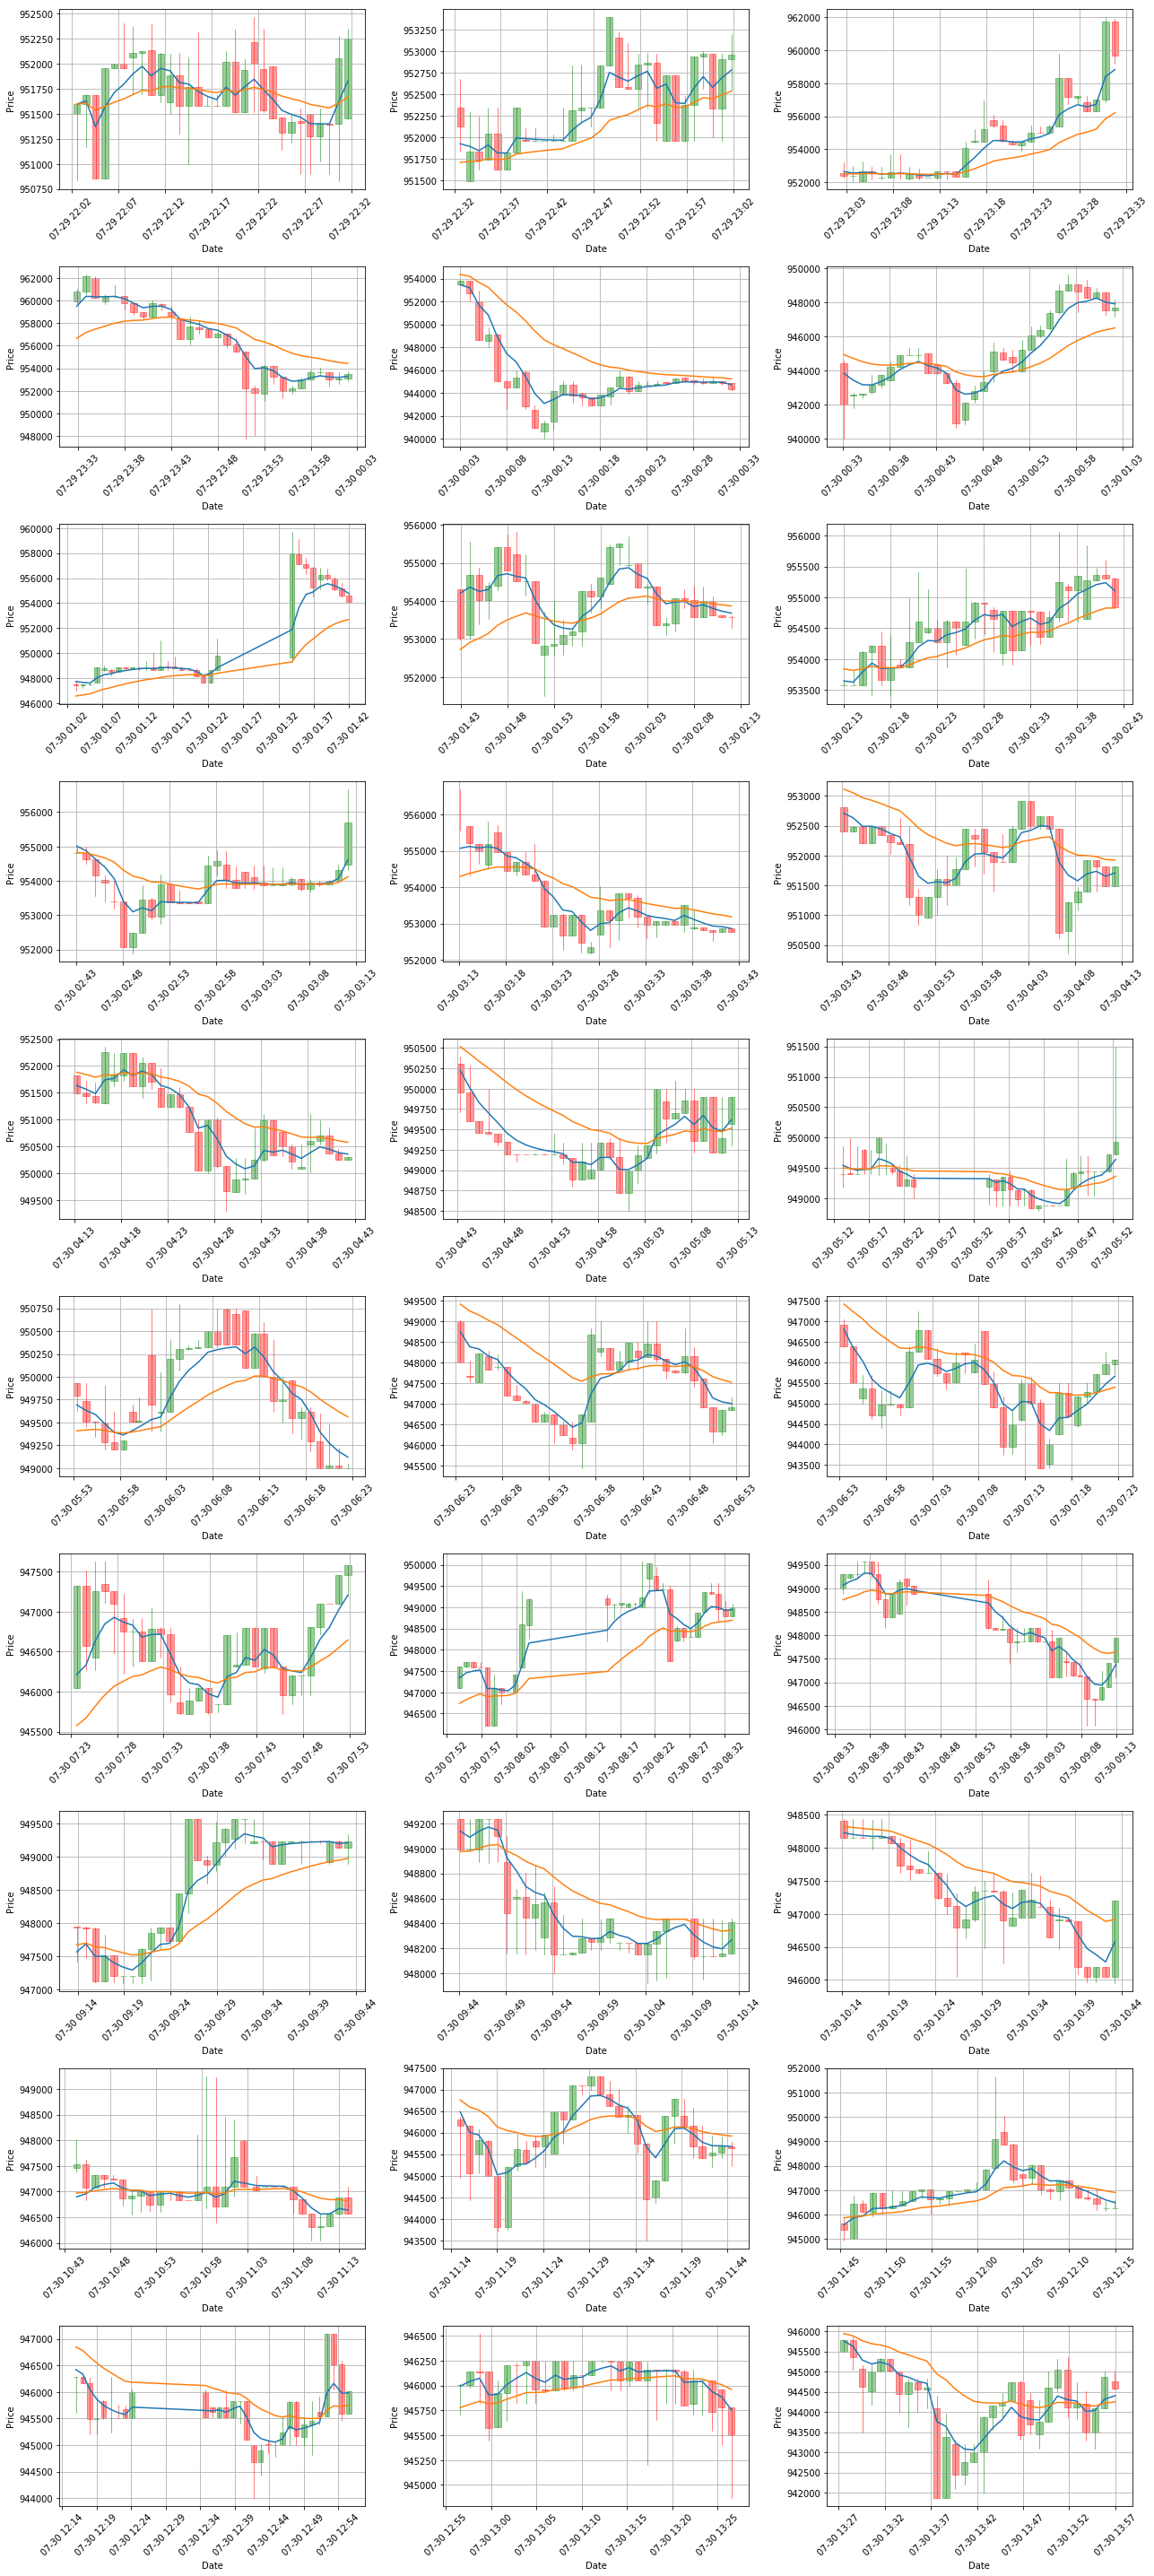

In [12]:
columns = ["Date", "Open", "High", "Low", "Close"]
start = 0
step = 30

fig = plt.figure(figsize=(18,40))
for ii in range(30):
    df_ = df[ii*step+start:(ii+1)*step+start]
    tuples = [tuple(x) for x in df_[columns].values]
    
    ax1 = fig.add_subplot(10, 3, ii + 1)
    ax1.xaxis_date()
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
    ax1.grid(True)
    plt.xticks(rotation=45)
    plt.xlabel("Date")
    plt.ylabel("Price")
#     plt.title("BTC-JPYFX / bitFlyer")
    candlestick_ohlc(ax1, tuples, width=0.0005,colorup='g', alpha =.4)
    
    x = df_["Date"].values
    ema1_ = ema1[ii*step+start:(ii+1)*step+start]
    ema2_ = ema2[ii*step+start:(ii+1)*step+start]
    ax1.plot(x, ema1_, label="EMA1")
    ax1.plot(x, ema2_, label="EMA2")

plt.tight_layout()
# plt.savefig("../images/ohlc_ema_{}_{}.png".format(5, 20), 
#             bbox_inches="tight", pad_inches=0.2)

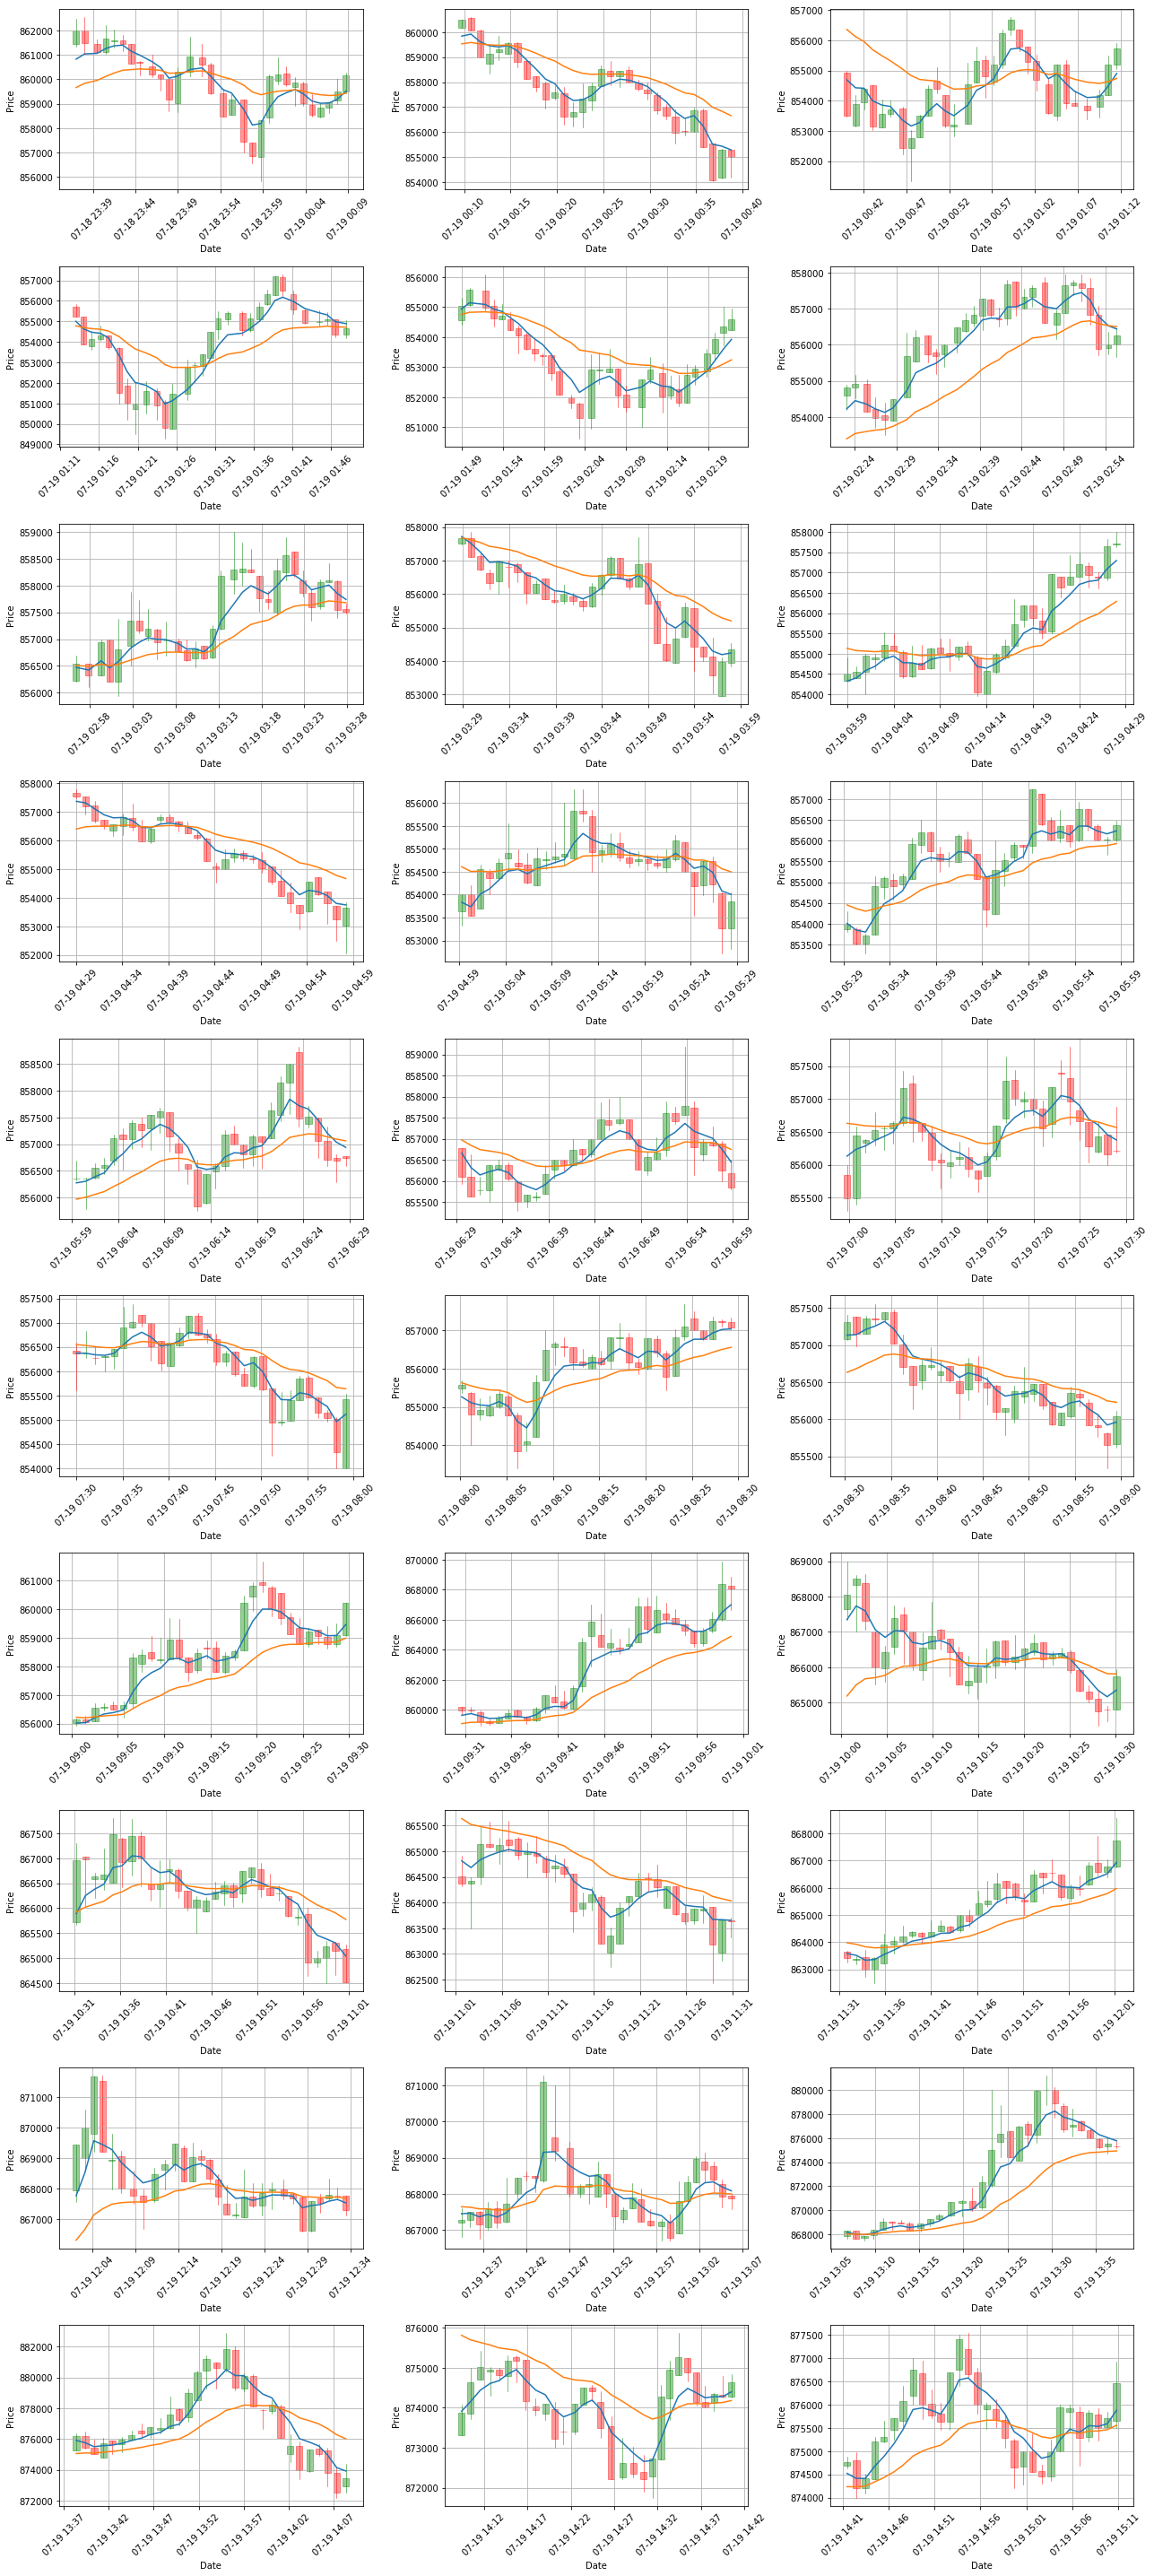

In [62]:
columns = ["Date", "Open", "High", "Low", "Close"]
start = 3600
step = 30

fig = plt.figure(figsize=(18,40))
for ii in range(30):
    df_ = df[ii*step+start:(ii+1)*step+start]
    tuples = [tuple(x) for x in df_[columns].values]
    
    ax1 = fig.add_subplot(10, 3, ii + 1)
    ax1.xaxis_date()
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
    ax1.grid(True)
    plt.xticks(rotation=45)
    plt.xlabel("Date")
    plt.ylabel("Price")
#     plt.title("BTC-JPYFX / bitFlyer")
    candlestick_ohlc(ax1, tuples, width=0.0005,colorup='g', alpha =.4)
    
    x = df_["Date"].values
    ema1_ = ema1[ii*step+start:(ii+1)*step+start]
    ema2_ = ema2[ii*step+start:(ii+1)*step+start]
    ax1.plot(x, ema1_, label="EMA1")
    ax1.plot(x, ema2_, label="EMA2")

plt.tight_layout()
# plt.savefig("../images/ohlc_ema_{}_{}.png".format(5, 20), 
#             bbox_inches="tight", pad_inches=0.2)

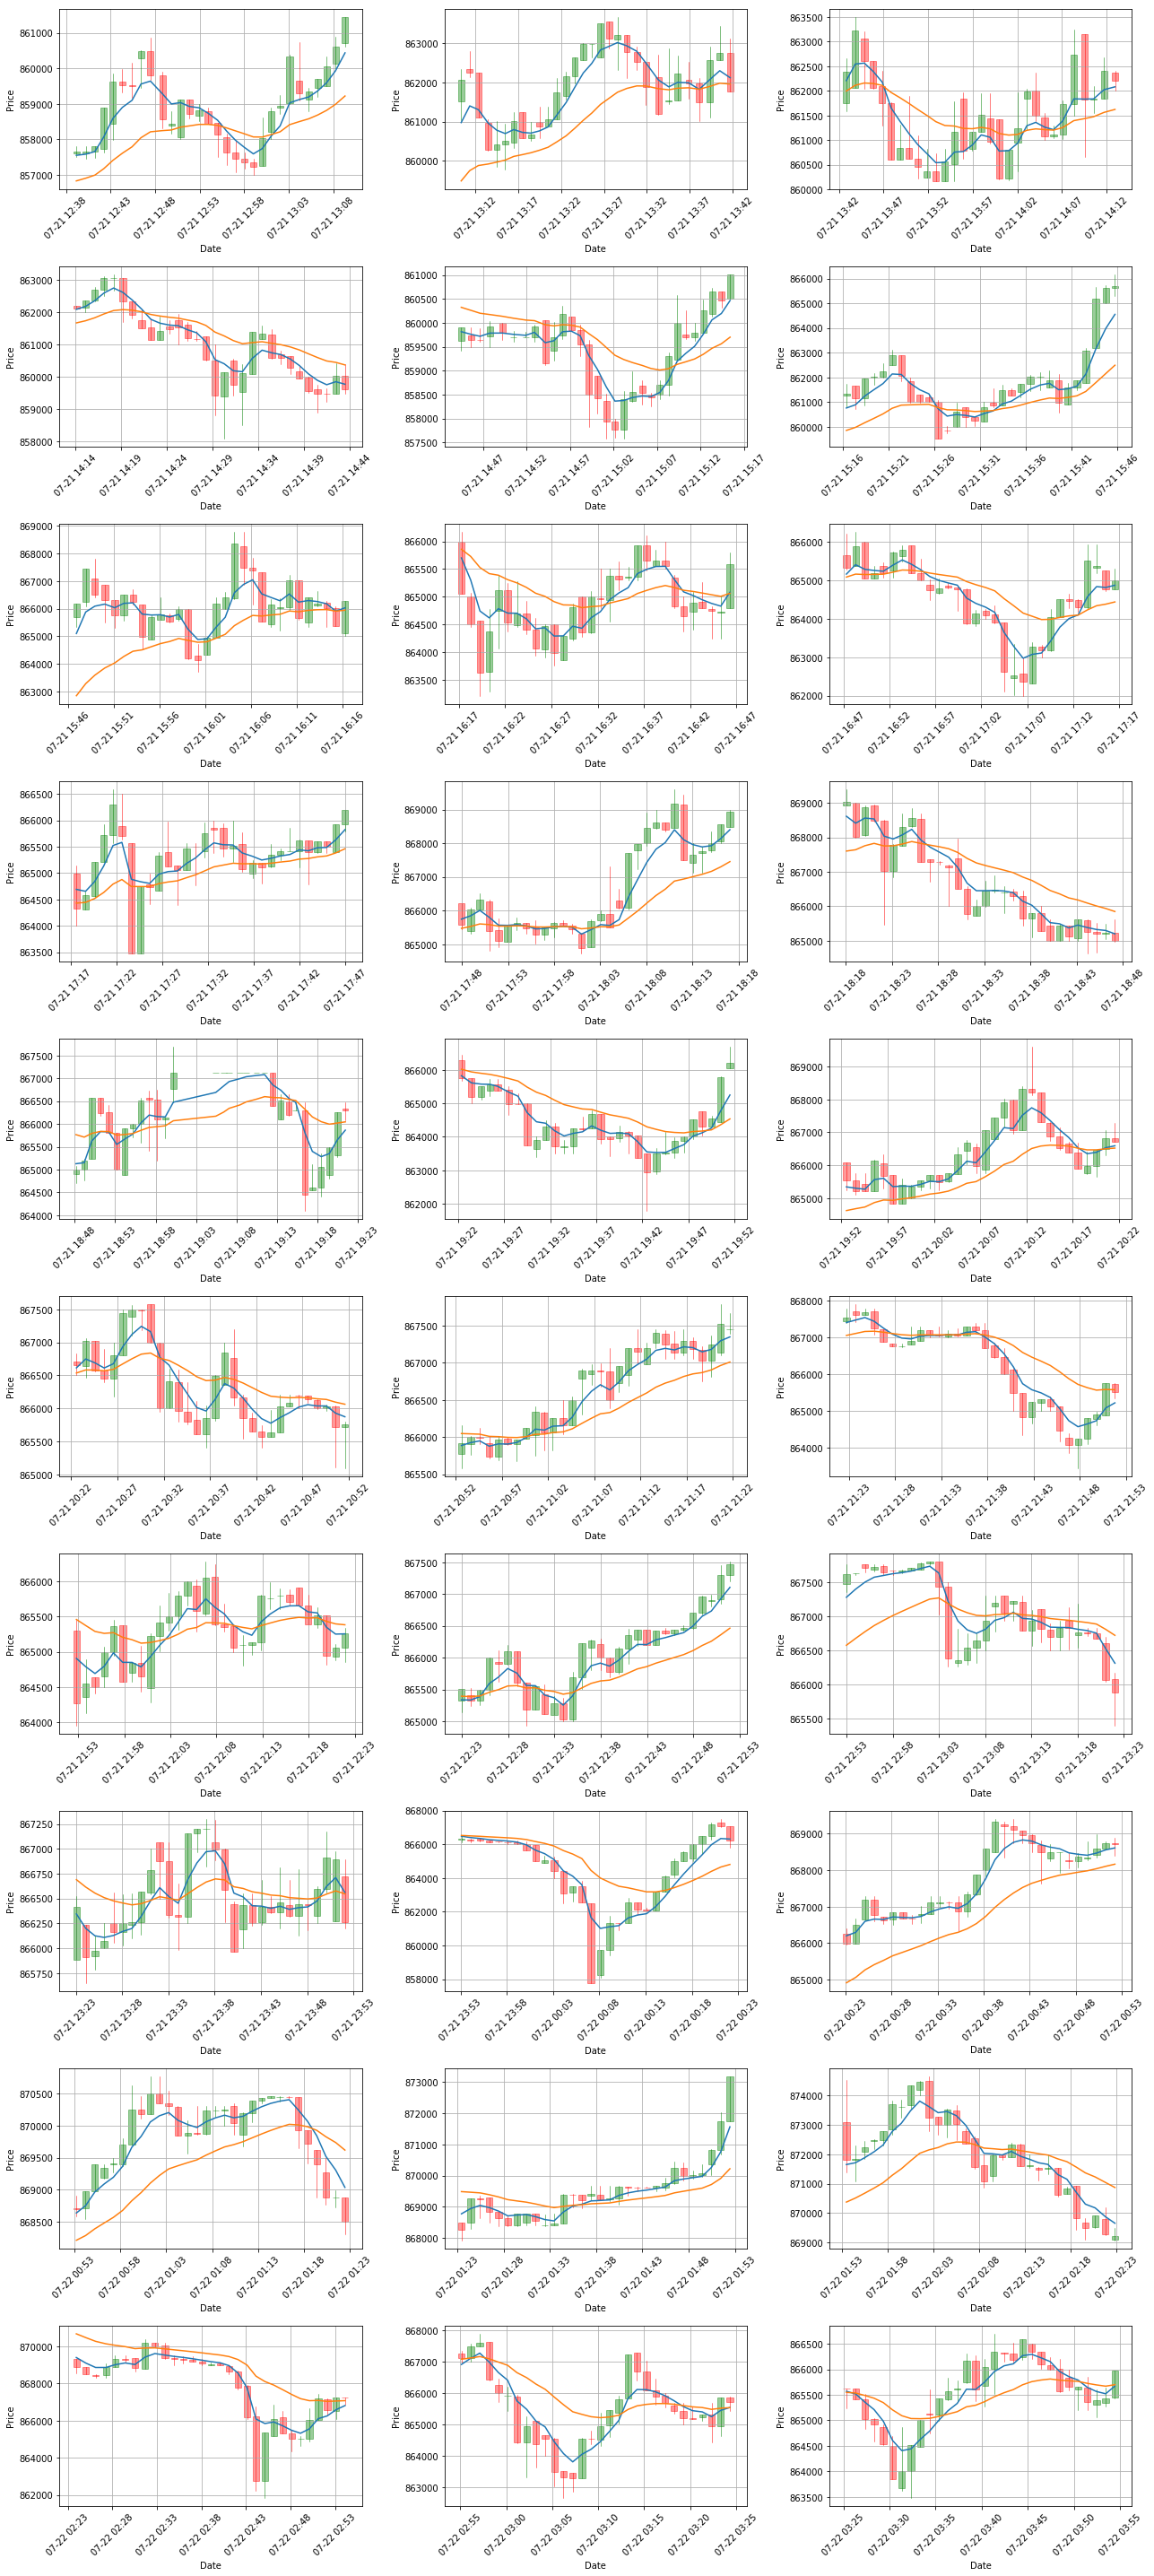

In [63]:
columns = ["Date", "Open", "High", "Low", "Close"]
start = 7200
step = 30

fig = plt.figure(figsize=(18,40))
for ii in range(30):
    df_ = df[ii*step+start:(ii+1)*step+start]
    tuples = [tuple(x) for x in df_[columns].values]
    
    ax1 = fig.add_subplot(10, 3, ii + 1)
    ax1.xaxis_date()
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
    ax1.grid(True)
    plt.xticks(rotation=45)
    plt.xlabel("Date")
    plt.ylabel("Price")
#     plt.title("BTC-JPYFX / bitFlyer")
    candlestick_ohlc(ax1, tuples, width=0.0005,colorup='g', alpha =.4)
    
    x = df_["Date"].values
    ema1_ = ema1[ii*step+start:(ii+1)*step+start]
    ema2_ = ema2[ii*step+start:(ii+1)*step+start]
    ax1.plot(x, ema1_, label="EMA1")
    ax1.plot(x, ema2_, label="EMA2")

plt.tight_layout()
# plt.savefig("../images/ohlc_ema_{}_{}.png".format(5, 20), 
#             bbox_inches="tight", pad_inches=0.2)

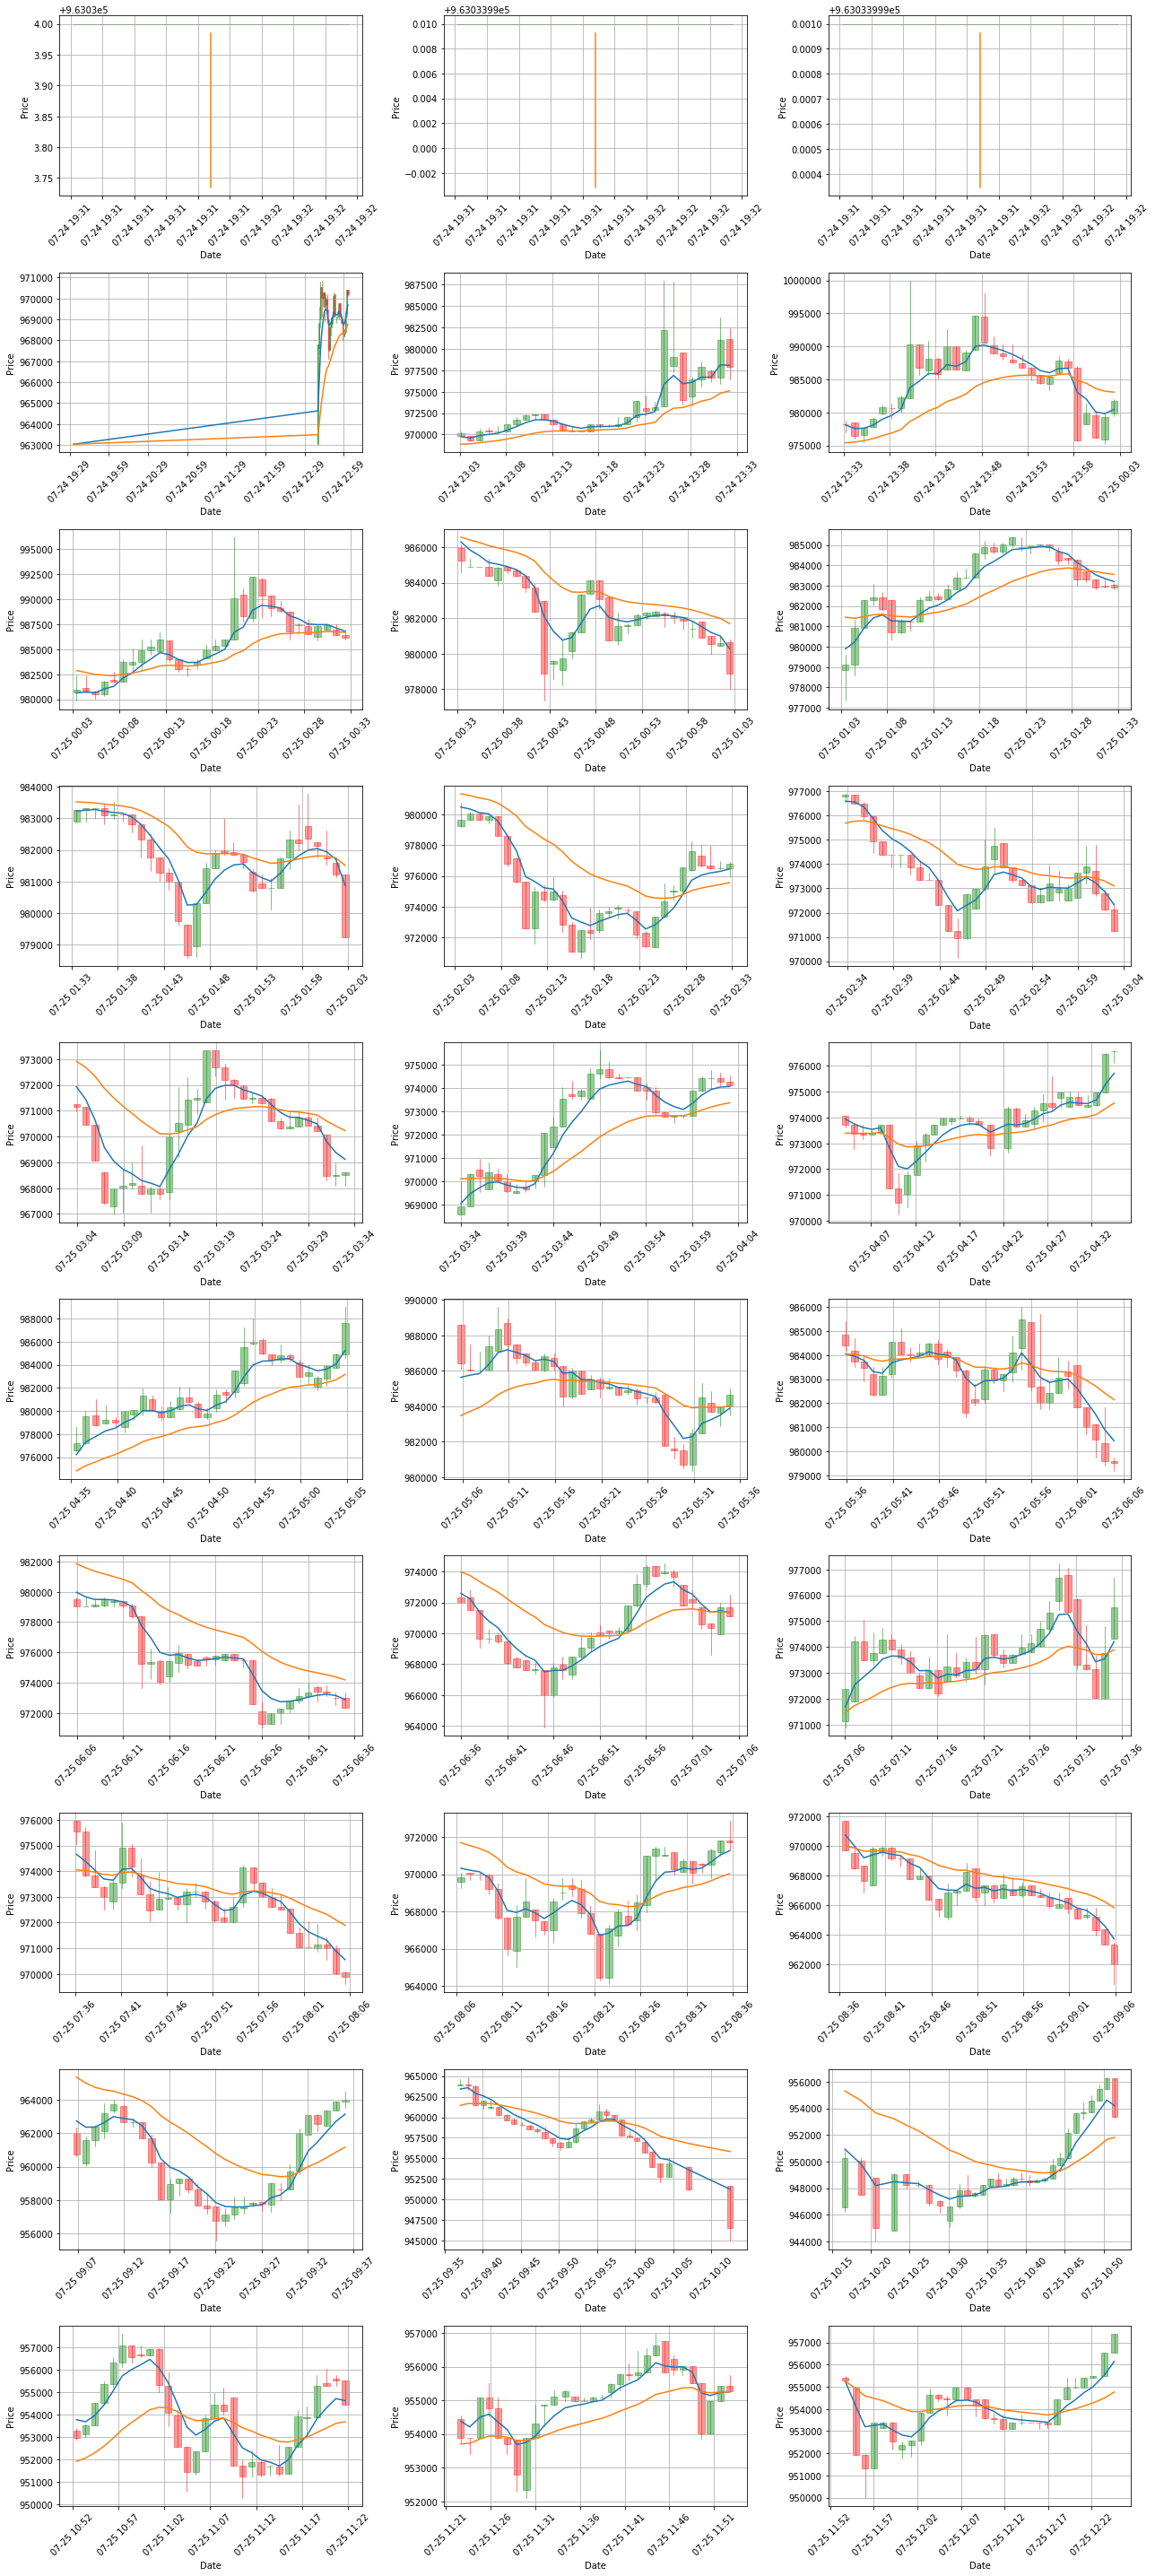

In [64]:
columns = ["Date", "Open", "High", "Low", "Close"]
start = 3600*3
step = 30

fig = plt.figure(figsize=(18,40))
for ii in range(30):
    df_ = df[ii*step+start:(ii+1)*step+start]
    tuples = [tuple(x) for x in df_[columns].values]
    
    ax1 = fig.add_subplot(10, 3, ii + 1)
    ax1.xaxis_date()
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
    ax1.grid(True)
    plt.xticks(rotation=45)
    plt.xlabel("Date")
    plt.ylabel("Price")
#     plt.title("BTC-JPYFX / bitFlyer")
    candlestick_ohlc(ax1, tuples, width=0.0005,colorup='g', alpha =.4)
    
    x = df_["Date"].values
    ema1_ = ema1[ii*step+start:(ii+1)*step+start]
    ema2_ = ema2[ii*step+start:(ii+1)*step+start]
    ax1.plot(x, ema1_, label="EMA1")
    ax1.plot(x, ema2_, label="EMA2")

plt.tight_layout()
# plt.savefig("../images/ohlc_ema_{}_{}.png".format(5, 20), 
#             bbox_inches="tight", pad_inches=0.2)

## cross pointの取得

In [111]:
cross_points = find_cross_points(ema1, ema2)

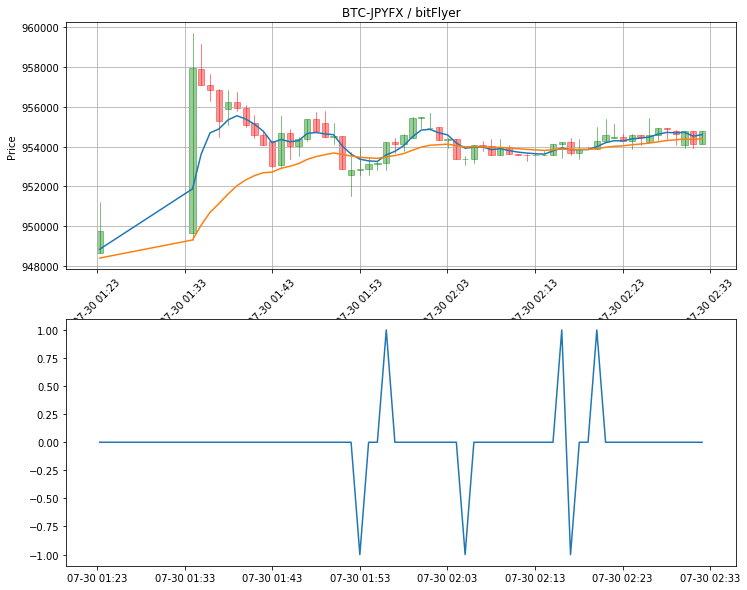

In [14]:
columns = ["Date", "Open", "High", "Low", "Close"]
start = 200
step = 60

df_ = df[start:step+start]
tuples = [tuple(x) for x in df_[columns].values]
x = df_["Date"].values
ema1_ = ema1[start:step+start]
ema2_ = ema2[start:step+start]
cross_ = cross_points[start:step+start]

fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(2, 1, 1)
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
ax1.grid(True)
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("BTC-JPYFX / bitFlyer")
candlestick_ohlc(ax1, tuples, width=0.0005,colorup='g', alpha =.4)

ax1.plot(x, ema1_, label="EMA1")
ax1.plot(x, ema2_, label="EMA2")

ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)
ax2.plot(x, cross_)

## 変分と激しさとレンジ

In [74]:
len(df)

17955

In [112]:
columns = ["Date", "Open", "High", "Low", "Close"]

df_ = df.copy()
tuples = [tuple(x) for x in df_[columns].values]
x = df_["Date"].values
cross_points = find_cross_points(ema1, ema2)

In [113]:
# 変分
df_["Var"] = df_["Close"] - df_["Open"]

# 激しさ
_ = pd.DataFrame(np.array([max(a, b) for a, b in zip(df_["Open"].values, df_["Close"].values)]), columns=["var"])
df_["UpperIntense"] = df_["High"].values - _["var"].values

_ = pd.DataFrame(np.array([min(a, b) for a, b in zip(df_["Open"].values, df_["Close"].values)]), columns=["var"])
df_["LowerIntense"] = _["var"].values - df_["Low"].values

# レンジ
df_["Range"] = df_["High"] - df_["Low"]

In [82]:
df_

,Open,High,Low,Close,Date,Var,UpperIntense,LowerIntense,Range
0,951501,951598,950832,951598,736904.918438,97,0,669,766
1,951599,951695,951165,951692,736904.919144,93,3,434,530
2,951692,951692,950854,950856,736904.919838,-836,0,2,838
3,950856,951955,950856,951955,736904.920532,1099,0,0,1099
4,951955,952004,951955,952003,736904.921227,48,1,0,49
5,952000,952404,951956,951958,736904.921921,-42,404,2,448
6,952063,952368,951693,952105,736904.922616,42,263,370,675
7,952105,952131,951693,952131,736904.923310,26,0,412,438
8,952132,952401,951688,951688,736904.924005,-444,269,0,713
9,951688,952105,951615,952104,736904.924699,416,1,73,490


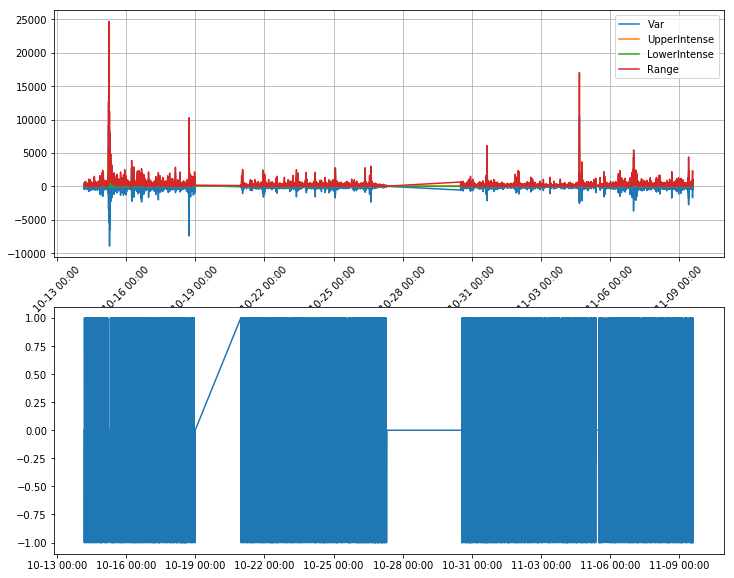

In [123]:
fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(2, 1, 1)
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
ax1.grid(True)
ax1.plot(x, df_["Var"])
ax1.plot(x, df_["UpperIntense"])
ax1.plot(x, df_["LowerIntense"])
ax1.plot(x, df_["Range"])
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.legend()

ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)
ax2.plot(x, cross_points)

(-35283.4, 35983.4)

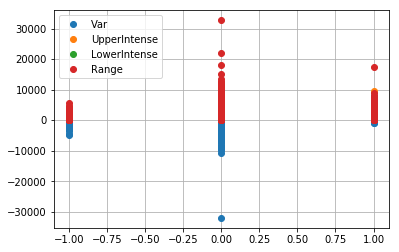

In [88]:
fig = plt.figure()
plt.plot(cross_points, df_["Var"], "o")
plt.plot(cross_points, df_["UpperIntense"], "o")
plt.plot(cross_points, df_["LowerIntense"], "o")
plt.plot(cross_points, df_["Range"], "o")
plt.legend()
plt.grid(True)
plt.ylim()

(-1114136109.6, 313386109.6)

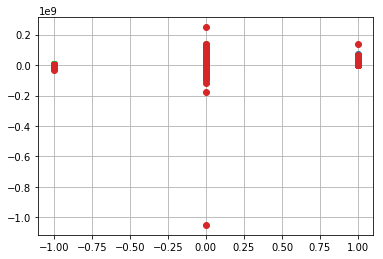

In [89]:
fig = plt.figure()
plt.plot(cross_points, df_["Var"]*df_["UpperIntense"], "o")
plt.plot(cross_points, df_["UpperIntense"]*df_["LowerIntense"], "o")
plt.plot(cross_points, df_["LowerIntense"]*df_["Range"], "o")
plt.plot(cross_points, df_["Range"]*df_["Var"], "o")
# plt.legend()
plt.grid(True)
plt.ylim()

符号化してみる。さきほどの４パラメータを、０以上を１、それ以外を０として二値化して並べる（1011など）。
それを１０進数に変換したものと、クロスポイントの出現の相関をとる。

In [90]:
ind1 = df_["Var"].values >= 0
ind2 = df_["UpperIntense"].values >= 0
ind3 = df_["LowerIntense"].values >= 0
ind4 = df_["Range"].values >= 0

symbolic = []
for a, b, c, d in zip(ind1, ind2, ind3, ind4):
    symbolic.append(int(str(int(a))+str(int(b))+str(int(c))+str(int(d)), 2))
symbolic = np.array(symbolic)

In [91]:
symbolic

array([15, 15,  7, ...,  7, 15, 15])

よくよく考えたら、定義からVar以外は０以上が確定しているので符号化は無意味。

## OHLCの符号化

In [60]:
def symbolize(dataFrame, k):
    """symbolize(dataFrame, k) -> numpy.1darray
    binalize a k-length OHLC dataset and then convert the binary to decimal number.  
    
    Parameters
    ----------
    dataFrame : pandas.DataFrame
    k : int
    
    Returns
    -------
    dec : numpy.1darray
    """
    if k <= 0:
        raise ValueError("k must be >=1.")
    var_ = (dataFrame["Close"] - dataFrame["Open"]).values
    dec = np.zeros(len(var_), int)
    
    for ii in range(k-1, len(var_)):
        ind_ = np.array(var_[ii-k+1:ii+1] >= 0, int)
        dec[ii] = int("".join([str(i_) for i_ in ind_]), 2)
    return dec

In [124]:
dec = symbolize(df_, 4)

(-0.75, 15.75)

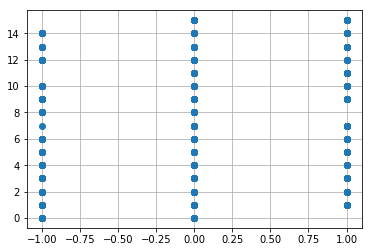

In [119]:
fig = plt.figure()
plt.plot(cross_points, dec, "o")
# plt.legend()
plt.grid(True)
plt.ylim()

cross pointと符号化されたC-Oの間には相関はない様子：同じ符号でどの場合も起こりうる。   
そもそもOpenとCloseはcross pointに対して相関を持たないので、符号化したところで相関はない？

## cross後の最大/最小の取得

次に検討すべきは、golden cross/dead cross後のEMAの差の最大/最小と、cross前後のOHLCまたはそれらから得られるパラメータの間に相関があるかどうか。

In [136]:
ind_ = cross_points != 0
a_k = np.vstack((np.arange(len(cross_points))[ind_], cross_points[ind_])).transpose().astype(int)
a_k

array([[    2,    -1],
       [   10,     1],
       [   16,    -1],
       ...,
       [29980,    -1],
       [29983,     1],
       [29993,    -1]])

In [137]:
close_ = df["Close"]

dec = symbolize(df_, 5)

ema_diff = ema1 - ema2
ema_diff_ext = np.zeros(len(a_k), int)
dec_ext = np.zeros(len(a_k), int)

for ii in range(len(a_k)-1):
    ind1, ind2 = a_k[ii][0], a_k[ii+1][0]
    v = a_k[ii][1]
    if v < 0:
        ema_diff_ext[ii] = ema_diff[ind1:ind2].max()
    else:
        ema_diff_ext[ii] = ema_diff[ind1:ind2].min()
    dec_ext[ii] = dec[ind1]

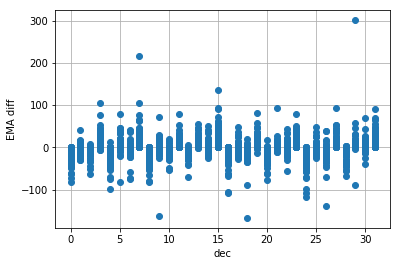

In [138]:
plt.plot(dec_ext, ema_diff_ext, "o")
plt.xlabel("dec")
plt.ylabel("EMA diff")
plt.grid(True)

まとめると、   

* パターン（k=3,4,5）とcross point(N1=5,N2=20)の現れるタイミングには相関がない。
* パターン（k=3,4,5）とcross point(N1=5,N2=20)後の最大/最小の値には相関がない。
    + 正と負のどちらに振れるというわけでもない。